In this notebook, I will perform the following tasks:
1.) Encode Data 
2.) Standardize Data
3.) Feature Selection and Feature Engineering
4.) Fit Models
5.) Evaluate Models

In [169]:
# Import Libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [170]:
# Set the environment to limit MKL threads
os.environ['OMP_NUM_THREADS']= '5'

In [171]:
# Load Data

data = pd.read_csv('tech_df_cleaned.csv', index_col=None)
data.describe(include='all')

,number_of_employees,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_offical_communication,mental_health_resources,mental_health_anonymity,asking_for_leave_for_mental_health,discussing_mental_health_with_employer,discussing_physical_health_with_employer,...,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,gender,country_residence,country_work,work_position,remote_work,age_group
count,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,...,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146
unique,6,2,4,4,3,3,3,6,3,3,...,2,2,5,5,3,7,7,180,3,6
top,26-100,Yes,Yes,No,No,No,I don't know,Somewhat easy,Maybe,No,...,No,Yes,Not applicable to me,Often,Male,North America,North America,Back-end Developer,Sometimes,30-39
freq,292,883,531,354,813,531,742,281,487,837,...,579,657,455,422,846,774,779,238,611,543


In [172]:
# Encode Data
# Encode Work Positions using MultiLabelBinarizer() because some participants have multiple roles.

one_hot_multiclass = MultiLabelBinarizer()
data_encoded = one_hot_multiclass.fit_transform(data['work_position'].str.split('|'))
data = pd.concat([data.drop(columns=['work_position']), pd.DataFrame(data_encoded, columns=one_hot_multiclass.classes_)], axis=1)
one_hot_multiclass.classes_

array(['Back-end Developer', 'Designer', 'Dev Evangelist/Advocate',
       'DevOps/SysAdmin', 'Executive Leadership', 'Front-end Developer',
       'HR', 'One-person shop', 'Other', 'Sales', 'Supervisor/Team Lead',
       'Support'], dtype=object)

In [173]:
# One hot encode categorical variables
# Use if_binary to drop one of the binary columns to avoid multicollinearity

categorical_columns = data.select_dtypes(include='object').columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')

one_hot_encoded = encoder.fit_transform(data[categorical_columns])

one_hot_data =pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

data = pd.concat([data.drop(columns=categorical_columns), one_hot_data], axis=1)

data.head()


,Back-end Developer,Designer,Dev Evangelist/Advocate,DevOps/SysAdmin,Executive Leadership,Front-end Developer,HR,One-person shop,Other,Sales,...,country_work_South America,remote_work_Always,remote_work_Never,remote_work_Sometimes,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60+,age_group_< 20
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,0,0,0,1,0,0,0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,1,1,1,1,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [174]:
# Inverse transform data to verify encoding

"""data_encoded = pd.concat([data.drop(columns=one_hot_data.columns), pd.DataFrame(encoder.inverse_transform(one_hot_data), columns=categorical_columns)], axis=1)

data_encoded.head()"""


'data_encoded = pd.concat([data.drop(columns=one_hot_data.columns), pd.DataFrame(encoder.inverse_transform(one_hot_data), columns=categorical_columns)], axis=1)\n\ndata_encoded.head()'

In [175]:
# No standardization or normalization needs to take place because all features are binary
# Dimensionality Reduction with PCA

pca= PCA(n_components=2)
pca_data = pca.fit_transform(data)
pca_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_data.shape

(1146, 2)

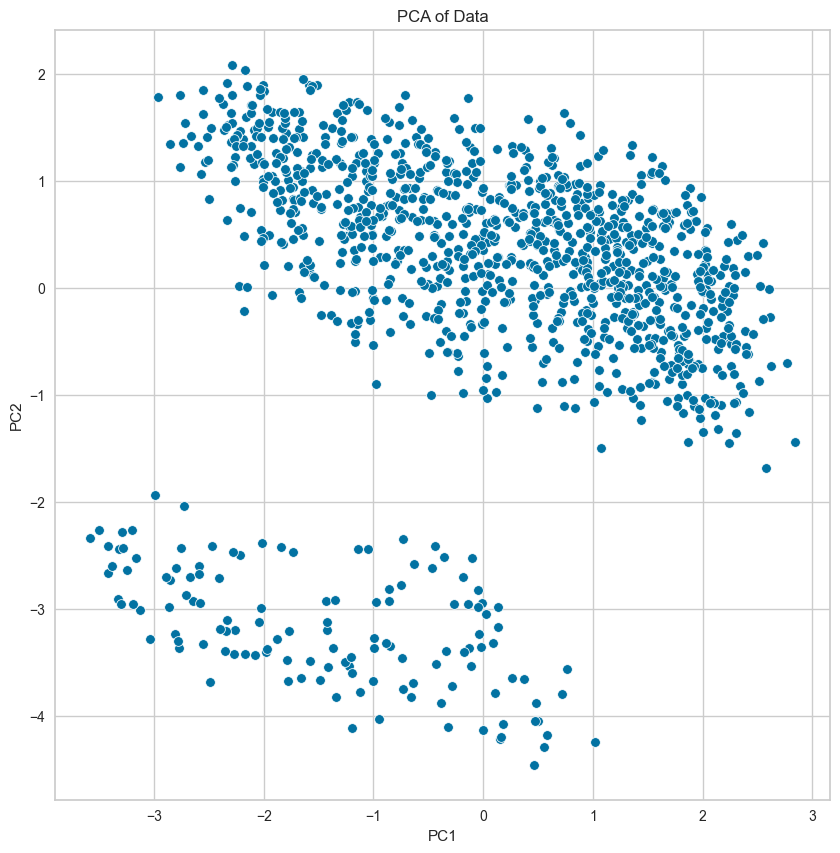

In [176]:
# Plot PCA Data

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', data=pca_data)
plt.title('PCA of Data')
plt.show()

C:\Users\alexa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\alexa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\alexa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\alexa\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Wi

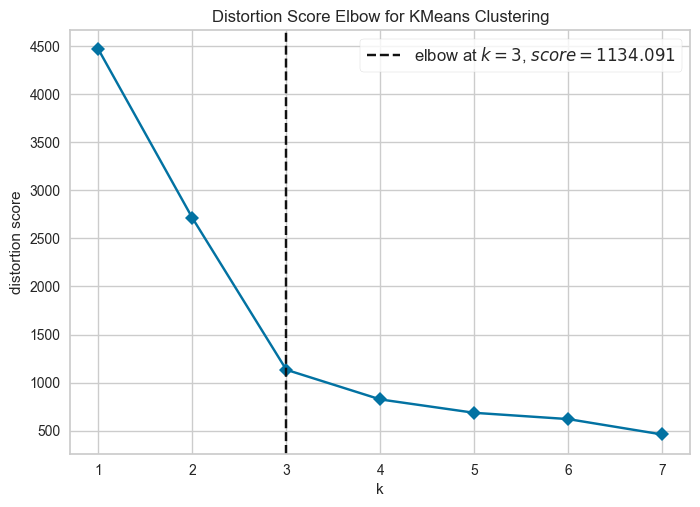

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [177]:
# In order to use K-Means clustering, first I want to use the elbow method to determine the optimal number of clusters

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 8), timings=False)

# Fit the data to the visualizer
visualizer.fit(pca_data)
visualizer.show()